# Model Selection

In [558]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import confusion_matrix

import pickle
                                      
%matplotlib inline

In [35]:
df = pd.read_csv('sample_data.csv')

# Training a classifier

### Train-Test split

Need to split the dataset into train and test, then use cross val to traing the classifier.

In [199]:
X = df.drop('star_rating',axis=1).as_matrix()

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30,
                                                    random_state=1,stratify=y)

### true values

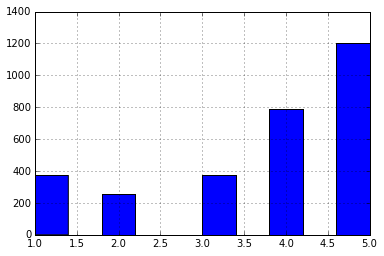

In [202]:
pd.Series(y_test).hist()

### baseline - highest frequency

In [72]:
dummy = DummyClassifier(strategy='most_frequent', random_state=1) 

In [73]:
dummy.fit(X_train,y_train)

DummyClassifier(constant=None, random_state=1, strategy='most_frequent')

In [74]:
preds = dummy.predict(X_test)

In [75]:
dummy.score(X_test,y_test)

0.40066666666666667

### informed prior

In [203]:
mnb = MultinomialNB(fit_prior=True).fit(X_train,y_train)

In [77]:
np.exp(mnb.class_log_prior_)

array([ 0.12414286,  0.08514286,  0.126     ,  0.264     ,  0.40071429])

In [204]:
preds = mnb.predict(X_test)

In [205]:
mnb.score(X_test,y_test)

0.54833333333333334

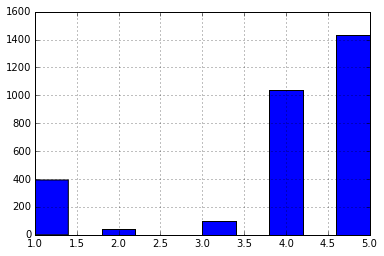

In [206]:
pd.Series(preds).hist()

# Feature Engineering: Inspecting Errors

/Users/justinstewart/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


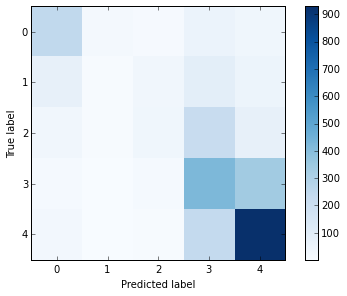

In [214]:
cm = confusion_matrix(y_test,preds,labels=[1,2,3,4,5])

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
# tick_marks = np.arange(len(iris.target_names))
# plt.xticks(tick_marks, iris.target_names, rotation=45)
# plt.yticks(tick_marks, iris.target_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [215]:
cm

array([[247,  20,  11,  57,  37],
       [ 74,   8,  30,  93,  51],
       [ 33,   8,  36, 224,  77],
       [ 13,   4,  13, 425, 337],
       [ 26,   1,   6, 240, 929]])

The class imbalance problem is dramatically skewing the results. Need to address the class imbalance problem.

# Over Sampling

In [220]:
os = df.head(1000)

In [241]:
def class_freqs(class_series):
    return dict(class_series.value_counts())

In [239]:
def normalize_to_dist(class_freq_dict):
    total  = sum([i for i in class_freq_dict.values()])
    return {k:(float(v)/total) for k,v in class_freq_dict.items()}    

In [329]:
def invert_class_dist(class_dist):
    assert sum(class_dist.values()) == 1
    return normalize_to_dist({k:(1-v) for k,v in class_dist.items()})

In [331]:
def get_sampling_rate(df):
    f = class_freqs(df.star_rating)
    d = normalize_to_dist(f)
    return invert_class_dist(d)

In [293]:
def oversample_stars(df,star_list,perc_increase=.1):
    
    df_to_sample = df[df.star_rating.isin(star_list)]
    count = len(df_to_sample)
    n = int(math.ceil(perc_increase*count))
    
    weights = get_sampling_rate(df_to_sample)
    sample_sizes = {k:(int(math.ceil(v*n))) for k,v in weights.items()}

    for key,size in sample_sizes.items():
        samp = df[df.star_rating == key].sample(n=size,replace=True)
        df = pd.concat([df,samp])
    return df

2-star and 3-star reviews are being misclassified often. We can resample the and add more to the data set to smooth it out. 

**reasonable parameter range**  : prec_increase 0,.1,...,1.9,2

# Cross validation

In [474]:
X = df.drop('star_rating',axis=1).as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30,
                                                    random_state=1,stratify=y)

In [504]:
os_rates = np.arange(0,3,.1)

In [ ]:
df_cv = pd.DataFrame(X_train)
df_cv['star_rating'] = np.array(y_train)

In [507]:
for rate in np.arange(0,.5,.1):
    df_os = oversample_stars(df_cv,[1,2,3],perc_increase=rate)
    print df_os.shape
    y_cv = np.array(df_os.pop('star_rating'))
    X_cv = df_os.as_matrix()
    skf = StratifiedKFold(y_cv, n_folds=3,random_state=1)
    score = cross_val_score(MultinomialNB(),X_cv,y_cv,cv=skf).mean()
    scores[rate] = score
    print rate, score

(7000, 28957)
0.0 0.534710739348
(7235, 28957)
0.1 0.547339698956
(7470, 28957)
0.2 0.564929241364
(7705, 28957)
0.3 0.589620200029
(7939, 28957)
0.4 0.601847795736


In [559]:
with open('scores.pkl', 'wb') as output:
    pickle.dump(scores, output, pickle.HIGHEST_PROTOCOL)

# Feature Engineering: clustering

In [39]:
star_counts = dict(df.star_rating.value_counts())
star_word_counts = df.groupby(['star_rating']).sum().T
for k,v in star_counts.items():
    star_word_counts[k] = groups[k]/v

In [40]:
star_word_counts.sort([5],ascending=False).head(30)

/Users/justinstewart/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


star_rating,1,2,3,4,5
great,0.114424,0.237089,0.353175,0.539394,0.583479
place,0.500403,0.647887,0.584921,0.574242,0.496132
food,0.534247,0.793427,0.680159,0.562121,0.436736
good,0.280419,0.637324,0.867460,0.721970,0.389069
time,0.445608,0.444836,0.367460,0.307197,0.329174
service,0.438356,0.484742,0.353175,0.313258,0.316446
like,0.402901,0.610329,0.541270,0.430682,0.309209
one,0.467365,0.471831,0.383333,0.358333,0.284253
best,0.064464,0.123239,0.134127,0.158712,0.282256
love,0.044319,0.116197,0.114286,0.167045,0.273272


In [106]:
star_word_counts_max = star_word_counts.sort_values(by=[5],ascending=False)
star_word_counts_max['maxes'] = star_word_counts_max.apply(max,axis=1)
frequent_words = star_word_counts_max[star_word_counts_max.maxes >= 0.5]

In [108]:
frequent_words.drop(['maxes'],inplace=True,axis=1)

/Users/justinstewart/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [109]:
word_sim = np.corrcoef(frequent_words.as_matrix())

In [138]:
spec = SpectralBiclustering(n_clusters=3)

In [139]:
spec.fit(word_sim)

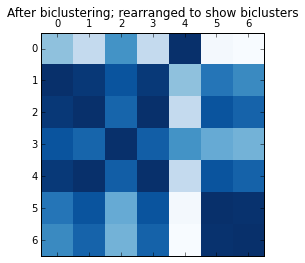

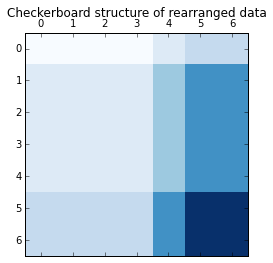

In [140]:
fit_data = word_sim[np.argsort(spec.row_labels_)]
fit_data = fit_data[:, np.argsort(spec.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

plt.matshow(np.outer(np.sort(spec.row_labels_) + 1,
                     np.sort(spec.column_labels_) + 1),
            cmap=plt.cm.Blues)
plt.title("Checkerboard structure of rearranged data")

plt.show()

### Accuracy Metrics

importnatn to consider what is the best accuracy measure to use to test results. notice that star rating is a ordered 